<a href="https://colab.research.google.com/github/AnzorGozalishvili/IOAI-2025-lectures/blob/main/lecture_29_transformers/notebooks/AnnotatedTransformerArchitectureOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<center><h1>The Annotated Transformer</h1> </center>


<center>
<p><a href="https://arxiv.org/abs/1706.03762">Attention is All You Need
</a></p>
</center>

<img src="https://github.com/harvardnlp/annotated-transformer/blob/master/images/aiayn.png?raw=1" width="70%"/>

* *v2022: Austin Huang, Suraj Subramanian, Jonathan Sum, Khalid Almubarak,
   and Stella Biderman.*
* *[Original](https://nlp.seas.harvard.edu/2018/04/03/attention.html):
   [Sasha Rush](http://rush-nlp.com/).*


The Transformer has been on a lot of
people's minds over the last <s>year</s> five years.
This post presents an annotated version of the paper in the
form of a line-by-line implementation. It reorders and deletes
some sections from the original paper and adds comments
throughout. This document itself is a working notebook, and should
be a completely usable implementation.
Code is available
[here](https://github.com/harvardnlp/annotated-transformer/).


<h3> Table of Contents </h3>
<ul>
<li><a href="#background">Background</a></li>
<li><a href="#part-1-model-architecture">Part 1: Model Architecture</a></li>
<li><a href="#model-architecture">Model Architecture</a><ul>
<li><a href="#encoder-and-decoder-stacks">Encoder and Decoder Stacks</a></li>
<li><a href="#position-wise-feed-forward-networks">Position-wise Feed-Forward
Networks</a></li>
<li><a href="#embeddings-and-softmax">Embeddings and Softmax</a></li>
<li><a href="#positional-encoding">Positional Encoding</a></li>
<li><a href="#full-model">Full Model</a></li>
<li><a href="#inference">Inference:</a></li>
</ul></li>

In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
import pandas as pd
import altair as alt
import warnings


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

# Background


The goal of reducing sequential computation also forms the
foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of
which use convolutional neural networks as basic building block,
computing hidden representations in parallel for all input and
output positions. In these models, the number of operations required
to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ConvS2S and
logarithmically for ByteNet. This makes it more difficult to learn
dependencies between distant positions. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of
reduced effective resolution due to averaging attention-weighted
positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention
mechanism relating different positions of a single sequence in order
to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading
comprehension, abstractive summarization, textual entailment and
learning task-independent sentence representations. End-to-end
memory networks are based on a recurrent attention mechanism instead
of sequencealigned recurrence and have been shown to perform well on
simple-language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first
transduction model relying entirely on self-attention to compute
representations of its input and output without using sequence
aligned RNNs or convolution.

# Part 1: Model Architecture

# Model Architecture


Most competitive neural sequence transduction models have an
encoder-decoder structure
[(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an
input sequence of symbol representations $(x_1, ..., x_n)$ to a
sequence of continuous representations $\mathbf{z} = (z_1, ...,
z_n)$. Given $\mathbf{z}$, the decoder then generates an output
sequence $(y_1,...,y_m)$ of symbols one element at a time. At each
step the model is auto-regressive
[(cite)](https://arxiv.org/abs/1308.0850), consuming the previously
generated symbols as additional input when generating the next.

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)


The Transformer follows this overall architecture using stacked
self-attention and point-wise, fully connected layers for both the
encoder and decoder, shown in the left and right halves of Figure 1,
respectively.

![](https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-21.png?raw=1)

## Encoder and Decoder Stacks

### Encoder

The encoder is composed of a stack of $N=6$ identical layers.

In [4]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


We employ a residual connection
[(cite)](https://arxiv.org/abs/1512.03385) around each of the two
sub-layers, followed by layer normalization
[(cite)](https://arxiv.org/abs/1607.06450).

In [6]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [13]:
# Create a manual tensor
x_3 = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0]], dtype=torch.float32)
x_5 = torch.tensor([[0.0, 1.0, 2.0, 3.0, 4.0],
                  [3.0, 4.0, 5.0, 6.0, 7.0]], dtype=torch.float32)

# Apply LayerNorm
normalized_x_3 = LayerNorm(features=3)(x_3)
normalized_x_5 = LayerNorm(features=5)(x_5)

print(normalized_x_3, normalized_x_3.mean().item(), normalized_x_3.std().item())
print(normalized_x_5, normalized_x_5.mean().item(), normalized_x_5.std().item())

tensor([[-1.0000,  0.0000,  1.0000],
        [-1.0000,  0.0000,  1.0000]], grad_fn=<AddBackward0>) 0.0 0.8944263458251953
tensor([[-1.2649, -0.6325,  0.0000,  0.6325,  1.2649],
        [-1.2649, -0.6325,  0.0000,  0.6325,  1.2649]], grad_fn=<AddBackward0>) 5.9604645663569045e-09 0.9428085088729858



That is, the output of each sub-layer is $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function
implemented by the sub-layer itself.  We apply dropout
[(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the
output of each sub-layer, before it is added to the sub-layer input
and normalized.

To facilitate these residual connections, all sub-layers in the
model, as well as the embedding layers, produce outputs of dimension
$d_{\text{model}}=512$.

In [14]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


Each layer has two sub-layers. The first is a multi-head
self-attention mechanism, and the second is a simple, position-wise
fully connected feed-forward network.

In [15]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.


In [17]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


In addition to the two sub-layers in each encoder layer, the decoder
inserts a third sub-layer, which performs multi-head attention over
the output of the encoder stack.  Similar to the encoder, we employ
residual connections around each of the sub-layers, followed by
layer normalization.

In [18]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


We also modify the self-attention sub-layer in the decoder stack to
prevent positions from attending to subsequent positions.  This
masking, combined with fact that the output embeddings are offset by
one position, ensures that the predictions for position $i$ can
depend only on the known outputs at positions less than $i$.

In [19]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [22]:
torch.triu(torch.ones(5, 5), diagonal=1)

tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [23]:
subsequent_mask(5).long()

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]])


> Below the attention mask shows the position each tgt word (row) is
> allowed to look at (column). Words are blocked for attending to
> future words during training.

In [24]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )

example_mask()

alt.Chart(...)

### Attention

An attention function can be described as mapping a query and a set
of key-value pairs to an output, where the query, keys, values, and
output are all vectors.  The output is computed as a weighted sum of
the values, where the weight assigned to each value is computed by a
compatibility function of the query with the corresponding key.

We call our particular attention "Scaled Dot-Product Attention".
The input consists of queries and keys of dimension $d_k$, and
values of dimension $d_v$.  We compute the dot products of the query
with all keys, divide each by $\sqrt{d_k}$, and apply a softmax
function to obtain the weights on the values.



![](https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-19.png?raw=1)


In practice, we compute the attention function on a set of queries
simultaneously, packed together into a matrix $Q$.  The keys and
values are also packed together into matrices $K$ and $V$.  We
compute the matrix of outputs as:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

In [26]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [28]:
# imagine query, key and value vectors of shape: (batch x sequence x dimension)
q = torch.randn(size=(2, 3, 5))
k = torch.randn(size=(2, 3, 5))
v = torch.randn(size=(2, 3, 5))

# this attention layer will return computed attention vectors of shape: (batch x sequence x dimension)
# and attention scores of shape: (batch x sequence x sequence)
_res, _attn = attention(q, k, v)
print(_res.shape, _attn.shape)
_res, _attn

torch.Size([2, 3, 5]) torch.Size([2, 3, 3])


(tensor([[[-0.0415, -0.8109, -0.0113, -0.8395, -0.5963],
          [ 0.2045, -0.5335, -0.2211, -0.9421, -0.3843],
          [ 0.2302, -0.3834, -0.0528, -0.7777, -0.4126]],
 
         [[-0.4273, -0.0610,  0.8257, -0.3441,  0.2297],
          [-0.5186, -0.0634,  1.1438, -0.3256,  0.1445],
          [-0.5065, -0.0661,  1.1204, -0.3339,  0.1336]]]),
 tensor([[[0.6624, 0.0812, 0.2563],
          [0.4809, 0.3166, 0.2025],
          [0.3558, 0.3336, 0.3106]],
 
         [[0.2743, 0.3910, 0.3347],
          [0.2169, 0.5606, 0.2224],
          [0.2278, 0.5514, 0.2208]]]))

In [39]:
# Step 1: Get query vectors dimension
_d_k = q.size(-1)
print(_d_k)

# Step 2: Scaled Dot Products
# q shape:            (batch x sequence x hidden_dim)
# k shape:            (batch x sequence x hidden_dim)
# transposed q shape: (batch x hidden_dim x sequence)
# dot product shape:  (batch x sequence x sequence)
_dp = torch.matmul(q, k.transpose(-2, -1))
print("\nDot Product:", _dp.shape, '\n', _dp[0, :, :])

_scaled_dp = _dp / math.sqrt(_d_k)
print("\nScaled Dot Product:", _scaled_dp.shape, '\n', _scaled_dp[0, :, :])
print("\nOriginal Vectors:", q.shape, '\n', q[0, :, :])

5

Dot Product: torch.Size([2, 3, 3]) 
 tensor([[ 2.5489, -2.1435,  0.4259],
        [-0.0101, -0.9447, -1.9441],
        [ 2.8124,  2.6687,  2.5087]])

Scaled Dot Product: torch.Size([2, 3, 3]) 
 tensor([[ 1.1399, -0.9586,  0.1905],
        [-0.0045, -0.4225, -0.8694],
        [ 1.2577,  1.1935,  1.1219]])

Original Vectors: torch.Size([2, 3, 5]) 
 tensor([[ 1.2802,  0.8851, -2.1002, -1.1783,  0.9709],
        [-1.5236,  0.8432, -0.4539, -1.0046,  0.8932],
        [ 1.2213, -1.1696,  1.9104, -0.9570, -0.3091]])


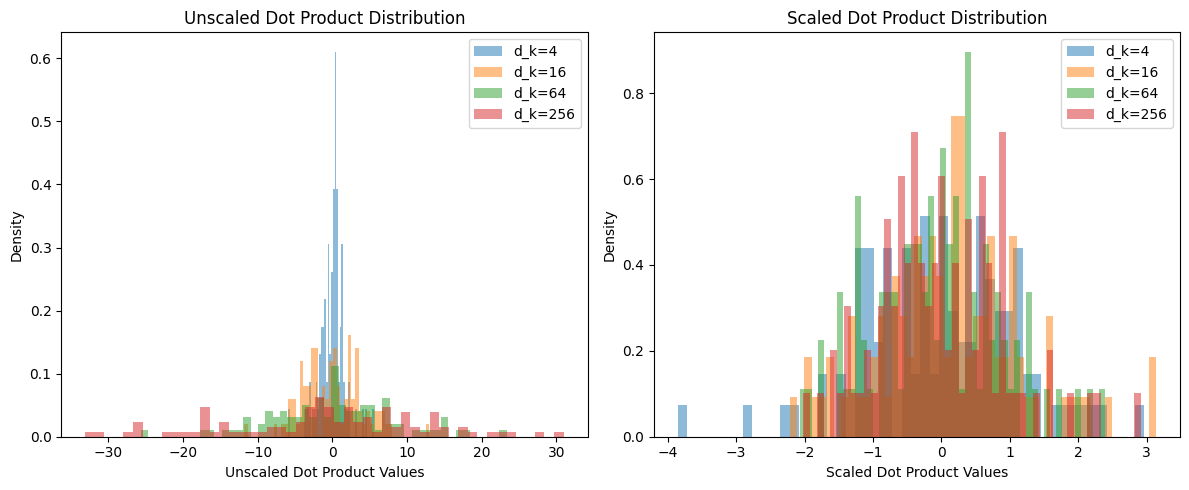

In [42]:
import torch
import math
import matplotlib.pyplot as plt

# Function to compute dot product with and without scaling
def compute_dot_product(d_k, batch=1, seq_len=10):
    q = torch.randn(batch, seq_len, d_k)  # Query matrix
    k = torch.randn(batch, seq_len, d_k)  # Key matrix

    dp = torch.matmul(q, k.transpose(-2, -1))  # Dot product (batch, seq, seq)
    scaled_dp = dp / math.sqrt(d_k)  # Scaled dot product

    return dp.view(-1).detach().numpy(), scaled_dp.view(-1).detach().numpy()

# Test with different hidden dimensions (d_k values)
d_k_values = [4, 16, 64, 256]

plt.figure(figsize=(12, 5))

# Plot for Unscaled Dot Products
plt.subplot(1, 2, 1)
for d_k in d_k_values:
    dp, _ = compute_dot_product(d_k)
    plt.hist(dp, bins=50, alpha=0.5, label=f"d_k={d_k}", density=True)
plt.xlabel("Unscaled Dot Product Values")
plt.ylabel("Density")
plt.title("Unscaled Dot Product Distribution")
plt.legend()

# Plot for Scaled Dot Products
plt.subplot(1, 2, 2)
for d_k in d_k_values:
    _, scaled_dp = compute_dot_product(d_k)
    plt.hist(scaled_dp, bins=50, alpha=0.5, label=f"d_k={d_k}", density=True)
plt.xlabel("Scaled Dot Product Values")
plt.ylabel("Density")
plt.title("Scaled Dot Product Distribution")
plt.legend()

plt.tight_layout()
plt.show()


The two most commonly used attention functions are additive
attention [(cite)](https://arxiv.org/abs/1409.0473), and dot-product
(multiplicative) attention.  Dot-product attention is identical to
our algorithm, except for the scaling factor of
$\frac{1}{\sqrt{d_k}}$. Additive attention computes the
compatibility function using a feed-forward network with a single
hidden layer.  While the two are similar in theoretical complexity,
dot-product attention is much faster and more space-efficient in
practice, since it can be implemented using highly optimized matrix
multiplication code.


While for small values of $d_k$ the two mechanisms perform
similarly, additive attention outperforms dot product attention
without scaling for larger values of $d_k$
[(cite)](https://arxiv.org/abs/1703.03906). We suspect that for
large values of $d_k$, the dot products grow large in magnitude,
pushing the softmax function into regions where it has extremely
small gradients (To illustrate why the dot products get large,
assume that the components of $q$ and $k$ are independent random
variables with mean $0$ and variance $1$.  Then their dot product,
$q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance
$d_k$.). To counteract this effect, we scale the dot products by
$\frac{1}{\sqrt{d_k}}$.



![](https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-20.png?raw=1)


Multi-head attention allows the model to jointly attend to
information from different representation subspaces at different
positions. With a single attention head, averaging inhibits this.

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ $h=8$ parallel attention layers, or
heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due
to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full
dimensionality.

In [44]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

In [45]:
# imagine query, key and value vectors of shape: (batch x sequence x dimension)
q = torch.randn(size=(2, 3, 4))
k = torch.randn(size=(2, 3, 4))
v = torch.randn(size=(2, 3, 4))

# returns multihead attention of shape: (batch x sequence x dimension)
mha_attn = MultiHeadedAttention(h=2, d_model=4, dropout=0.5)
mha_attn_result = mha_attn(q, k, v)

In [46]:
# 1) Do all the linear projections in batch from d_model => h x d_k
# NOTE: unfolded loop from above

res = []
for w, x in zip(mha_attn.linears, (q, k, v)):
    # linear layer transforming q, k, v vectors into same shapes since in=out dimensions
    wx = w(x)
    # reshaping into (batch x sequence x heads x hidden/heads)
    out = wx.view(q.size(0), -1, 2, q.size(2) // 2)
    # then transposing into (batch x heads x sequence x hidden/heads)
    out = out.transpose(1, 2) # reshaping into heads!
    res.append(out)

    print(w.weight.shape, wx.shape, x.shape, out.shape)

qs, ks, vs = res

[item.shape for item in qs], [item.shape for item in ks], [item.shape for item in vs]
qs

torch.Size([4, 4]) torch.Size([2, 3, 4]) torch.Size([2, 3, 4]) torch.Size([2, 2, 3, 2])
torch.Size([4, 4]) torch.Size([2, 3, 4]) torch.Size([2, 3, 4]) torch.Size([2, 2, 3, 2])
torch.Size([4, 4]) torch.Size([2, 3, 4]) torch.Size([2, 3, 4]) torch.Size([2, 2, 3, 2])


tensor([[[[-0.7947,  0.6746],
          [ 0.0956, -0.1242],
          [-0.2661,  0.2187]],

         [[ 0.1360,  0.9305],
          [-0.1490,  0.1969],
          [-0.7584,  0.6788]]],


        [[[-0.4123,  0.2555],
          [ 0.6226, -0.5250],
          [-0.1576,  0.2945]],

         [[ 0.3673,  0.4598],
          [ 0.4214, -0.6015],
          [ 0.1135,  0.4982]]]], grad_fn=<TransposeBackward0>)

In [47]:
# 2) Apply attention on all the projected vectors in batch.
# attention keeps vector dimensions so we have (batch x heads x sequence x dim)
# attention scores are for pairs so we have (batch x heads x sequence x sequence)
out_2, attn_2 = attention(
    qs, ks, vs, mask=None, dropout=mha_attn.dropout
)

print(out_2.shape, attn_2.shape)
out_2, attn_2

torch.Size([2, 2, 3, 2]) torch.Size([2, 2, 3, 3])


(tensor([[[[ 0.0000,  0.0000],
           [-0.3298, -0.3734],
           [-0.2362, -0.6810]],
 
          [[-0.2328,  0.2598],
           [ 0.2979, -1.3032],
           [ 0.1764, -0.5851]]],
 
 
         [[[ 0.1388, -0.0220],
           [-0.5594,  0.2518],
           [-0.4801,  0.2321]],
 
          [[ 0.2940,  0.1249],
           [ 0.3401,  0.1445],
           [ 1.0288,  0.0778]]]], grad_fn=<UnsafeViewBackward0>),
 tensor([[[[0.0000, 0.0000, 0.0000],
           [0.7079, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.8125]],
 
          [[0.3548, 0.5073, 0.0000],
           [0.6393, 0.0000, 0.7481],
           [0.0000, 0.4510, 0.9342]]],
 
 
         [[[0.0000, 0.0000, 0.8733],
           [0.6231, 1.0066, 0.3703],
           [0.6387, 0.5636, 0.7977]],
 
          [[0.5164, 0.0000, 0.0000],
           [0.5974, 0.0000, 0.0000],
           [0.5865, 0.6136, 0.7999]]]], grad_fn=<MulBackward0>))

In [48]:
# 3) "Concat" using a view and apply a final linear.
# NOTE: We go back to where we started at. Dimensions are same (batch x sequence x dim)
out_3 = (
    out_2.transpose(1, 2)
    .contiguous()
    .view(out_2.size(0), -1, out_2.size(1) * out_2.size(3))
)
out_3.shape
out_3

tensor([[[ 0.0000,  0.0000, -0.2328,  0.2598],
         [-0.3298, -0.3734,  0.2979, -1.3032],
         [-0.2362, -0.6810,  0.1764, -0.5851]],

        [[ 0.1388, -0.0220,  0.2940,  0.1249],
         [-0.5594,  0.2518,  0.3401,  0.1445],
         [-0.4801,  0.2321,  1.0288,  0.0778]]], grad_fn=<ViewBackward0>)

### Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways:
1) In "encoder-decoder attention" layers, the queries come from the
previous decoder layer, and the memory keys and values come from the
output of the encoder.  This allows every position in the decoder to
attend over all positions in the input sequence.  This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence
models such as [(cite)](https://arxiv.org/abs/1609.08144).


2) The encoder contains self-attention layers.  In a self-attention
layer all of the keys, values and queries come from the same place,
in this case, the output of the previous layer in the encoder.  Each
position in the encoder can attend to all positions in the previous
layer of the encoder.


3) Similarly, self-attention layers in the decoder allow each
position in the decoder to attend to all positions in the decoder up
to and including that position.  We need to prevent leftward
information flow in the decoder to preserve the auto-regressive
property.  We implement this inside of scaled dot-product attention
by masking out (setting to $-\infty$) all values in the input of the
softmax which correspond to illegal connections.

## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our
encoder and decoder contains a fully connected feed-forward network,
which is applied to each position separately and identically.  This
consists of two linear transformations with a ReLU activation in
between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different
positions, they use different parameters from layer to
layer. Another way of describing this is as two convolutions with
kernel size 1.  The dimensionality of input and output is
$d_{\text{model}}=512$, and the inner-layer has dimensionality
$d_{ff}=2048$.

In [50]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [62]:
# imagine contextual vectors of shape: (batch x sequence x dimension)
v = torch.randn(size=(2, 3, 4))

ff_v = PositionwiseFeedForward(d_model=4, d_ff=8, dropout=0.5)(v)
print(v.shape, ff_v.shape)
print(v)
print(ff_v)

# The upscaling and relu activation transforms into high-dimensional feature space,
# capturing more abstract features.
# The downscaling is done to make sure it matches the original dimension
# Dropount hints a fight for curse of high dimensionality

torch.Size([2, 3, 4]) torch.Size([2, 3, 4])
tensor([[[ 1.1683, -0.6158, -0.9419, -0.2326],
         [ 0.5583,  0.6814,  0.0328, -0.9558],
         [ 0.1785, -1.9330,  0.5818,  1.9294]],

        [[-0.4754, -0.8661,  1.0486, -0.4029],
         [-1.2042,  1.4570,  0.4389, -0.1914],
         [-0.7964,  0.9230, -0.8256,  2.5939]]])
tensor([[[-0.3357, -0.2786,  0.3003,  0.3377],
         [-0.9477,  0.3079,  0.5113,  0.6862],
         [-1.4061, -0.2526,  0.4453,  1.5028]],

        [[-0.2729, -0.1502,  0.1721,  0.3170],
         [-1.1066,  0.6706,  0.7511,  0.5695],
         [-1.3809, -0.0673,  0.7390,  0.4679]]], grad_fn=<ViewBackward0>)


## Embeddings and Softmax

Similarly to other sequence transduction models, we use learned
embeddings to convert the input tokens and output tokens to vectors
of dimension $d_{\text{model}}$.  We also use the usual learned
linear transformation and softmax function to convert the decoder
output to predicted next-token probabilities.  In our model, we
share the same weight matrix between the two embedding layers and
the pre-softmax linear transformation, similar to
[(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers,
we multiply those weights by $\sqrt{d_{\text{model}}}$.

In [71]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [74]:
# Showing randomly initialized embedding of first word from vocabulary
Embeddings(5, 100)(torch.LongTensor([0]))

# The reason for upscaling is to isolate embedding scale from model's required scale in attention operations
# Attention's dot product + softmax operations might have too small values without scaling

tensor([[-1.5731,  3.3907, -1.7001, -5.8939, -3.6506]], grad_fn=<MulBackward0>)

## Positional Encoding

Since our model contains no recurrence and no convolution, in order
for the model to make use of the order of the sequence, we must
inject some information about the relative or absolute position of
the tokens in the sequence.  To this end, we add "positional
encodings" to the input embeddings at the bottoms of the encoder and
decoder stacks.  The positional encodings have the same dimension
$d_{\text{model}}$ as the embeddings, so that the two can be summed.
There are many choices of positional encodings, learned and fixed
[(cite)](https://arxiv.org/pdf/1705.03122.pdf).

In this work, we use sine and cosine functions of different frequencies:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

where $pos$ is the position and $i$ is the dimension.  That is, each
dimension of the positional encoding corresponds to a sinusoid.  The
wavelengths form a geometric progression from $2\pi$ to $10000 \cdot
2\pi$.  We chose this function because we hypothesized it would
allow the model to easily learn to attend by relative positions,
since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a
linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks.  For
the base model, we use a rate of $P_{drop}=0.1$.



In [88]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


> Below the positional encoding will add in a sine wave based on
> position. The frequency and offset of the wave is different for
> each dimension.

In [89]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


example_positional()

alt.Chart(...)


We also experimented with using learned positional embeddings
[(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found
that the two versions produced nearly identical results.  We chose
the sinusoidal version because it may allow the model to extrapolate
to sequence lengths longer than the ones encountered during
training.

## Full Model

> Here we define a function from hyperparameters to a full model.

In [90]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with (Xavier) Glorot / fan_avg. - paper (Xavier Glorot and Yoshua Bengio)
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [101]:
model = make_model(src_vocab=2, tgt_vocab=2, N=6, d_model=8, d_ff=16, h=2, dropout=0.1)
model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=8, out_features=16, bias=True)
          (w_2): Linear(in_features=16, out_features=8, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=8, out_features=8, bi

## Inference:

> Here we make a forward step to generate a prediction of the
model. We try to use our transformer to memorize the input. As you
will see the output is randomly generated due to the fact that the
model is not trained yet. In the next tutorial we will build the
training function and try to train our model to memorize the numbers
from 1 to 10.

In [113]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()

run_tests()

Example Untrained Model Prediction: tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 6, 7, 9, 6, 7, 9, 6, 7, 9]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 5, 8, 9, 8, 9, 8, 9, 8, 9]])
Example Untrained Model Prediction: tensor([[0, 5, 6, 3, 0, 5, 6, 3, 0, 5]])
Example Untrained Model Prediction: tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
Example Untrained Model Prediction: tensor([[0, 2, 5, 5, 5, 5, 5, 5, 5, 5]])
Example Untrained Model Prediction: tensor([[0, 6, 4, 9, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[0, 8, 5, 2, 2, 2, 2, 2, 2, 2]])
